# 1. Document Classification

In [2]:
import tensorflow as tf
print(tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

2.4.1


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# import xml.etree.ElementTree as ET
from lxml import etree


## (a) Preprocess

In [5]:
def import_pretrained_embeddings(path):
    embeddings_dict = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
    return embeddings_dict

In [6]:
def import_data(filepaths_dict, embedding):    
    x_all = []
    y_all = []
    
    for label, filepath in filepaths_dict.items():
        # get rows from .txt file
        with open(filepath) as f:
            reader = f.read()
            reader = reader.split("\n\n")

            tokenized_paragraphs = []
            print(f"class {label} has {len(reader)} samples")
            # iterate through every text row to clean it up
            for sample_idx, paragraph in enumerate(reader):
                # 1. remove punctuations
                paragraph = paragraph.translate(str.maketrans('','',string.punctuation))
                paragraph = paragraph.replace('\n', ' ')
                # 2. tokenize
                tokens = nltk.word_tokenize(paragraph)
                # 3. remove stop words

                vectors = []
                
                for token in tokens:
                    if not token in stop_words:
                        try:
                            vector = embedding[token.lower()]
                            vectors.append(vector)
                        except KeyError:
                            continue
                            
                x_all.append(vectors)
                y_all.append(label)
                
    return x_all, y_all

In [7]:
def extract_text_from_reviews(path_to_file):
    reviews = []

    root = etree.parse(path_to_file)

    for review_tag in root.findall('review'):
        text = review_tag.find('review_text')

        reviews.append(text.text)
    
    return reviews
        
    
def embed_text(text_list, embeddings_dict):
    x_all = []
    for sample_idx, sample in enumerate(text_list):
        # 1. remove punctuations
        sample = sample.translate(str.maketrans('','',string.punctuation))
        sample = sample.replace('\n', ' ')
        
        # 2. tokenize
        tokens = nltk.word_tokenize(sample)
        
        # 3. remove stop words
        vectors = []
        for token in tokens:
            if not token in stop_words:
                try:
                    vector = embeddings_dict[token.lower()]
                    vectors.append(vector)
                except KeyError:
                    continue
        if len(vectors) > 0:            
            x_all.append(vectors)
    return x_all


Run the functions defined above

In [8]:
embeddings_dict = import_pretrained_embeddings('glove.6B.50d.txt')

In [9]:
stop_words = set(nltk.corpus.stopwords.words('english'))

### IF PART 1:

In [406]:
filepaths_dict = {'0': './a4-data/q1/fd.txt',
            '1': './a4-data/q1/acd.txt',
            '2': './a4-data/q1/ja.txt'}

x, y = import_data(filepaths_dict, embeddings_dict)

class 0 has 6055 samples
class 1 has 2548 samples
class 2 has 11495 samples


In [407]:
assert(len(x) == len(y) == 6055+2548+11495)

### IF PART 2:

In [138]:
filepaths_dict = {'1': './a4-data/q2/positive.review.xml',
             '0': './a4-data/q2/negative.review.xml'}

x, y = [], []
for label, filepath in filepaths_dict.items():
    reviews = extract_text_from_reviews(filepath)

    embedded_reviews = embed_text(reviews, embeddings_dict)

    x.extend(embedded_reviews)
    y.extend([int(label)]*len(embedded_reviews))

    


In [139]:
vocab_size = len(embeddings_dict.keys())

In [140]:
y = np.array(y)
# y = tf.keras.utils.to_categorical(y_arr, num_classes=len(filepaths_dict.keys()))

In [141]:
len_sample=500
x = tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=len_sample)


In [142]:
print(f"The samples are distributed as: {sum(y==1)}")

The samples are distributed as: 1000


In [143]:
# assert(len(x) == len(y) == 2000)

### Split into training and testing

In [144]:
X_train, x, y_train, y = train_test_split(x, y, train_size=1500, random_state=42, stratify=y_arr)

In [145]:
X_val, X_test, y_val, y_test = train_test_split(x, y, train_size=400, random_state=28)

In [146]:
print("Sizes of sets:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

Sizes of sets:
X_train: (1500, 500, 50)
y_train: (1500,)
X_val: (400, 500, 50)
y_val: (400,)
X_test (99, 500, 50)
y_test (99,)


There is an obscure bug with the Tensorflow + CuDNN install for GPUs that occurs when there is a remainder when creating batches of data. To avoid this error, I adjusted the dataset lengths to be exact multiples of the batchsize.

## (b,c) Build and train your models

In [147]:
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0.001, patience=10, verbose=1, 
        restore_best_weights=True
        )
# checkpoint = tf.keras.callbacks.ModelCheckpoint(
#         filepath=checkpoint_filepath, 
#         )



In [148]:
# class_weights = {0: 1.106, 1:1.8, 2:0.5828}

### LSTM using only last hidden state

In [154]:
# define model
last_hs_model = tf.keras.Sequential(name="lstm1-5")
# last_hs_model.add(tf.keras.layers.Embedding(vocab_size, 50, input_length=500))
# model.add(tf.keras.layers.LSTM(100, return_sequences=True))
last_hs_model.add(tf.keras.layers.LSTM(20, batch_input_shape=(50,len_sample,50)))
# last_hs_model.add(tf.keras.layers.Dropout(0.4))
last_hs_model.add(tf.keras.layers.Dense(4, activation='relu'))
last_hs_model.add(tf.keras.layers.Dropout(0.4))

if len(filepaths_dict.keys()) == 2:
    last_hs_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
else:
    last_hs_model.add(tf.keras.layers.Dense(3, activation='softmax'))

print(last_hs_model.summary())

Model: "lstm1-5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (50, 20)                  5680      
_________________________________________________________________
dense_48 (Dense)             (50, 4)                   84        
_________________________________________________________________
dropout_25 (Dropout)         (50, 4)                   0         
_________________________________________________________________
dense_49 (Dense)             (50, 1)                   5         
Total params: 5,769
Trainable params: 5,769
Non-trainable params: 0
_________________________________________________________________
None


In [155]:
# if part 1:
# last_hs_model.compile(
#             optimizer=tf.keras.optimizers.Adam(),
#             loss='categorical_crossentropy', metrics=['accuracy'])
# if part 2:
last_hs_model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss='binary_crossentropy', metrics=['accuracy'])

In [156]:
last_hs_history = last_hs_model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), 
                                    batch_size=50, epochs=100, callbacks=[early_stopping]
#                                    class_weight=class_weights
                                   )

Epoch 1/100
30/30 [==============================] - 4s 98ms/step - loss: 0.7034 - accuracy: 0.4968 - val_loss: 0.6890 - val_accuracy: 0.5550
Epoch 2/100
30/30 [==============================] - 3s 90ms/step - loss: 0.6901 - accuracy: 0.5304 - val_loss: 0.6877 - val_accuracy: 0.5550
Epoch 3/100
30/30 [==============================] - 3s 90ms/step - loss: 0.6783 - accuracy: 0.5521 - val_loss: 0.6897 - val_accuracy: 0.5275
Epoch 4/100
30/30 [==============================] - 3s 90ms/step - loss: 0.6679 - accuracy: 0.5731 - val_loss: 0.6699 - val_accuracy: 0.5825
Epoch 5/100
30/30 [==============================] - 3s 89ms/step - loss: 0.6479 - accuracy: 0.6157 - val_loss: 0.6546 - val_accuracy: 0.6100
Epoch 6/100
30/30 [==============================] - 3s 90ms/step - loss: 0.6289 - accuracy: 0.6336 - val_loss: 0.6470 - val_accuracy: 0.6350
Epoch 7/100
30/30 [==============================] - 3s 90ms/step - loss: 0.6163 - accuracy: 0.6504 - val_loss: 0.6429 - val_accuracy: 0.6400
Epoch 

In [566]:
last_hs_model.save(str("models/" + last_hs_model.name))

INFO:tensorflow:Assets written to: models/lstm1-4/assets


INFO:tensorflow:Assets written to: models/lstm1-4/assets


### LSTM using the element wise average of all the hidden states

In [162]:
# define model
all_hs_model = tf.keras.Sequential(name="lstm2.4")
# all_hs_model.add(tf.keras.layers.Embedding(vocab_size, 50))
all_hs_model.add(tf.keras.layers.LSTM(100, return_sequences=True, batch_input_shape=(50,len_sample,50)))
all_hs_model.add(tf.keras.layers.GlobalAveragePooling1D())
all_hs_model.add(tf.keras.layers.Dense(64, activation='relu'))
all_hs_model.add(tf.keras.layers.Dropout(0.4))
# all_hs_model.add(tf.keras.layers.Dense(16, activation='relu'))
# all_hs_model.add(tf.keras.layers.Dropout(0.2))
if len(filepaths_dict.keys()) == 2:
    last_hs_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
else:
    last_hs_model.add(tf.keras.layers.Dense(3, activation='softmax'))
print(all_hs_model.summary())

Model: "lstm2.4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (50, 500, 100)            60400     
_________________________________________________________________
global_average_pooling1d_1 ( (50, 100)                 0         
_________________________________________________________________
dense_52 (Dense)             (50, 64)                  6464      
_________________________________________________________________
dropout_27 (Dropout)         (50, 64)                  0         
Total params: 66,864
Trainable params: 66,864
Non-trainable params: 0
_________________________________________________________________
None


In [163]:
# if part 1:
# all_hs_model.compile(
#             optimizer=tf.keras.optimizers.Adam(),
#             loss='categorical_crossentropy', metrics=['accuracy'])
# if part 2:
all_hs_model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss='binary_crossentropy', metrics=['accuracy'])

In [164]:
all_hs_history = all_hs_model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), 
                                  batch_size=50, epochs=100, callbacks=[early_stopping],
#                                  class_weight=class_weights
                                 )

Epoch 1/100
30/30 [==============================] - 7s 212ms/step - loss: 5.2152 - accuracy: 0.0000e+00 - val_loss: 2.5129 - val_accuracy: 0.0000e+00
Epoch 2/100
30/30 [==============================] - 6s 205ms/step - loss: 4.4490 - accuracy: 0.0000e+00 - val_loss: 2.1098 - val_accuracy: 0.0000e+00
Epoch 3/100
10/30 [=========>....................] - ETA: 3s - loss: 4.3603 - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [553]:
all_hs_model.save(str("models/" + all_hs_model.name))

INFO:tensorflow:Assets written to: models/lstm2.4/assets


INFO:tensorflow:Assets written to: models/lstm2.4/assets


### CNN model

In [55]:
cnn_model = tf.keras.Sequential(name="cnn_6")
cnn_model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', batch_input_shape=(50,len_sample,50)))
cnn_model.add(tf.keras.layers.MaxPooling1D())
cnn_model.add(tf.keras.layers.Flatten())
# cnn_model.add(tf.keras.layers.Dropout(0.4))
cnn_model.add(tf.keras.layers.Dense(32, activation='relu'))
cnn_model.add(tf.keras.layers.Dropout(0.4))
# cnn_model.add(tf.keras.layers.Dense(8, activation='relu'))
# cnn_model.add(tf.keras.layers.Dropout(0.1))
cnn_model.add(tf.keras.layers.Dense(len(filepaths_dict.keys()), activation='softmax'))

print(cnn_model.summary())

Model: "cnn_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (50, 498, 64)             9664      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (50, 249, 64)             0         
_________________________________________________________________
flatten_10 (Flatten)         (50, 15936)               0         
_________________________________________________________________
dense_24 (Dense)             (50, 32)                  509984    
_________________________________________________________________
dropout_13 (Dropout)         (50, 32)                  0         
_________________________________________________________________
dense_25 (Dense)             (50, 2)                   66        
Total params: 519,714
Trainable params: 519,714
Non-trainable params: 0
_______________________________________________________

In [56]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', metrics=['accuracy'])

In [57]:
cnn_history = cnn_model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), 
                            batch_size=50, epochs=50, callbacks=[early_stopping],
#                            class_weight=class_weights
                           )

Epoch 1/50
30/30 [==============================] - 1s 24ms/step - loss: 0.7092 - accuracy: 0.5096 - val_loss: 0.6958 - val_accuracy: 0.5100
Epoch 2/50
30/30 [==============================] - 1s 21ms/step - loss: 0.6867 - accuracy: 0.5408 - val_loss: 0.6900 - val_accuracy: 0.5350
Epoch 3/50
30/30 [==============================] - 1s 23ms/step - loss: 0.6856 - accuracy: 0.5721 - val_loss: 0.6930 - val_accuracy: 0.5150
Epoch 4/50
30/30 [==============================] - 1s 21ms/step - loss: 0.6622 - accuracy: 0.6146 - val_loss: 0.6933 - val_accuracy: 0.5375
Epoch 5/50
30/30 [==============================] - 1s 21ms/step - loss: 0.6641 - accuracy: 0.6104 - val_loss: 0.7027 - val_accuracy: 0.5225
Epoch 6/50
30/30 [==============================] - 1s 21ms/step - loss: 0.6511 - accuracy: 0.6329 - val_loss: 0.6956 - val_accuracy: 0.5075
Epoch 7/50
30/30 [==============================] - 1s 21ms/step - loss: 0.6338 - accuracy: 0.6453 - val_loss: 0.6983 - val_accuracy: 0.5350
Epoch 8/50
30

In [58]:
cnn_model.save(str("models/" + cnn_model.name))

INFO:tensorflow:Assets written to: models/cnn_6/assets


In [49]:
def plot_loss(history, title):
    plt.plot(history.history['loss'], color='y', label='training loss')
    plt.plot(history.history['val_loss'], color='r', label='validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title(title)
    plt.legend()
    plt.show()

In [50]:
def plot_accuracy(history, title):
    plt.plot(history.history['accuracy'], color='y', label='training accuracy')
    plt.plot(history.history['val_accuracy'], color='r', label='validation accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title(title)
    plt.legend()
    plt.show()    

In [51]:
plot_loss(last_hs_history, 'LSTM model using last hidden state to predict')
plot_loss(all_hs_history, 'LSTM model using average of hidden states')
plot_loss(cnn_history, 'CNN model')

NameError: name 'last_hs_history' is not defined

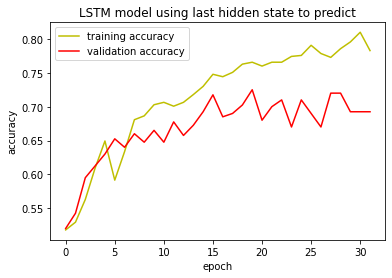

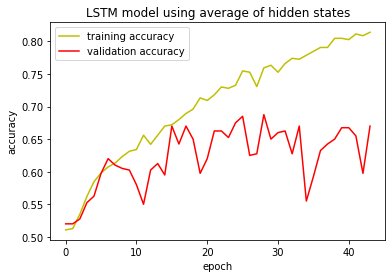

NameError: name 'cnn_history' is not defined

In [563]:
plot_accuracy(last_hs_history, 'LSTM model using last hidden state to predict')
plot_accuracy(all_hs_history, 'LSTM model using average of hidden states')
plot_accuracy(cnn_history, 'CNN model')

## (d) Report Recall, Precision, F1 
for each class on the test data

### Load model and predict on test data

In [59]:
loaded_model = tf.keras.models.load_model(
    "models/cnn_6", custom_objects=None, compile=True, options=None
)


In [60]:
y_pred = loaded_model.predict(X_test, batch_size=1, verbose=1)

99/99 [==============================] - 0s 704us/step


In [61]:
y_pred = np.argmax(y_pred, axis=1)

In [62]:
print(y_test.shape)
print(y_pred.shape)

(99, 2)
(99,)


In [63]:
y_test = np.argmax(y_test, axis=1)

In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.45      0.60        55
           1       0.57      0.91      0.70        44

    accuracy                           0.66        99
   macro avg       0.72      0.68      0.65        99
weighted avg       0.73      0.66      0.64        99

